# 📊 Notebook de Entrenamiento - Retail Forecasting

Este notebook contiene el proceso completo de entrenamiento del modelo predictivo para la forecasting de ventas retail.

## Estructura del Notebook:
1. **Carga de Datos**: Importación de datasets de ventas y competencia
2. **Análisis de Calidad**: Validación y limpieza de datos
3. **Análisis Exploratorio (EDA)**: Visualizaciones y patrones
4. **Ingeniería de Features**: Creación de variables temporales, lags, y encoding
5. **Modelado**: Entrenamiento y evaluación del modelo
6. **Validación**: Análisis de predicciones en noviembre 2024
7. **Modelo Final**: Entrenamiento con todos los datos y guardado


In [91]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
import os
from datetime import datetime
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.inspection import permutation_importance
import joblib


---

## 1️⃣ Carga de Datos

Cargamos los datasets de ventas y competencia desde la carpeta de datos raw.


In [92]:
# Definir el path relativo desde la carpeta notebooks
base_path = os.path.join('..', 'data', 'raw', 'Entrenamiento')
ventas_path = os.path.join(base_path, 'ventas.csv')
competencia_path = os.path.join(base_path, 'competencia.csv')

# Cargar los archivos CSV
ventas = pd.read_csv(ventas_path)
competencia = pd.read_csv(competencia_path)

print(f'✓ Ventas cargadas: {ventas.shape[0]} filas, {ventas.shape[1]} columnas')
print(f'✓ Competencia cargada: {competencia.shape[0]} filas, {competencia.shape[1]} columnas')


✓ Ventas cargadas: 3552 filas, 10 columnas
✓ Competencia cargada: 3552 filas, 5 columnas


### Vista previa de los datos


In [ ]:
ventas.head()

,fecha,producto_id,nombre,categoria,subcategoria,precio_base,es_estrella,unidades_vendidas,precio_venta,ingresos
0,2021-10-25,PROD_001,Nike Air Zoom Pegasus 40,Running,Zapatillas Running,115,True,6,118.36,710.16
1,2021-10-25,PROD_002,Adidas Ultraboost 23,Running,Zapatillas Running,135,True,10,136.82,1368.20
2,2021-10-25,PROD_003,Asics Gel Nimbus 25,Running,Zapatillas Running,85,False,2,84.93,169.86
3,2021-10-25,PROD_004,New Balance Fresh Foam X 1080v12,Running,Zapatillas Running,75,False,2,75.42,150.84
4,2021-10-25,PROD_005,Nike Dri-FIT Miler,Running,Ropa Running,35,False,2,35.87,71.74


In [94]:
competencia.head()

,fecha,producto_id,Amazon,Decathlon,Deporvillage
0,2021-10-25,PROD_001,82.96,111.88,97.43
1,2021-10-25,PROD_002,112.56,108.61,115.58
2,2021-10-25,PROD_003,79.79,78.44,80.11
3,2021-10-25,PROD_004,72.60,67.29,74.45
4,2021-10-25,PROD_005,37.71,33.60,33.07


In [95]:
ventas.columns, competencia.columns

(Index(['fecha', 'producto_id', 'nombre', 'categoria', 'subcategoria',
        'precio_base', 'es_estrella', 'unidades_vendidas', 'precio_venta',
        'ingresos'],
       dtype='object'),
 Index(['fecha', 'producto_id', 'Amazon', 'Decathlon', 'Deporvillage'], dtype='object'))

---

## 2️⃣ Análisis de Calidad de Datos

Validamos la calidad de los datos antes de proceder con el análisis.


### 2.1 Validación del dataset de Ventas


In [96]:
# Validación de la calidad de datos de ventas

# 1. Tipos de datos
print('📋 Tipos de datos:')
print(ventas.dtypes)
print('\n')

# 2. Valores nulos
print('❌ Valores nulos por columna:')
print(ventas.isnull().sum())
print('\n')

# 3. Duplicados
num_duplicados = ventas.duplicated().sum()
print(f'🔄 Registros duplicados: {num_duplicados}')
print('\n')

# 4. Estadísticas descriptivas
print('📊 Estadísticas descriptivas:')
print(ventas.describe())
print('\n')

# 5. Informe final de calidad de datos
print('='*50)
print('📝 INFORME DE CALIDAD DE DATOS - VENTAS')
print('='*50)
print(f"Filas totales: {ventas.shape[0]}")
print(f"Columnas totales: {ventas.shape[1]}")
print(f"Registros duplicados: {num_duplicados}")
print(f"Columnas con nulos: {ventas.columns[ventas.isnull().any()].tolist()}")


📋 Tipos de datos:
fecha                 object
producto_id           object
nombre                object
categoria             object
subcategoria          object
precio_base            int64
es_estrella             bool
unidades_vendidas      int64
precio_venta         float64
ingresos             float64
dtype: object


❌ Valores nulos por columna:
fecha                0
producto_id          0
nombre               0
categoria            0
subcategoria         0
precio_base          0
es_estrella          0
unidades_vendidas    0
precio_venta         0
ingresos             0
dtype: int64


🔄 Registros duplicados: 0


📊 Estadísticas descriptivas:
       precio_base  unidades_vendidas  precio_venta      ingresos
count  3552.000000         3552.00000   3552.000000   3552.000000
mean    123.125000            4.87866    121.816546    605.972323
std     165.576753            6.31102    164.017963   1079.071192
min      20.000000            1.00000     19.000000     19.460000
25%      48.750

### 2.2 Validación del dataset de Competencia


In [97]:
# Validación de la calidad de datos de competencia

# 1. Tipos de datos
print('📋 Tipos de datos:')
print(competencia.dtypes)
print('\n')

# 2. Valores nulos
print('❌ Valores nulos por columna:')
print(competencia.isnull().sum())
print('\n')

# 3. Duplicados
num_duplicados_comp = competencia.duplicated().sum()
print(f'🔄 Registros duplicados: {num_duplicados_comp}')
print('\n')

# 4. Estadísticas descriptivas
print('📊 Estadísticas descriptivas:')
print(competencia.describe())
print('\n')

# 5. Informe final de calidad de datos
print('='*50)
print('📝 INFORME DE CALIDAD DE DATOS - COMPETENCIA')
print('='*50)
print(f"Filas totales: {competencia.shape[0]}")
print(f"Columnas totales: {competencia.shape[1]}")
print(f"Registros duplicados: {num_duplicados_comp}")
print(f"Columnas con nulos: {competencia.columns[competencia.isnull().any()].tolist()}")


📋 Tipos de datos:
fecha            object
producto_id      object
Amazon          float64
Decathlon       float64
Deporvillage    float64
dtype: object


❌ Valores nulos por columna:
fecha           0
producto_id     0
Amazon          0
Decathlon       0
Deporvillage    0
dtype: int64


🔄 Registros duplicados: 0


📊 Estadísticas descriptivas:
            Amazon    Decathlon  Deporvillage
count  3552.000000  3552.000000   3552.000000
mean    118.623407   111.412182    118.894628
std     156.095628   148.508132    160.216448
min      16.850000    15.450000     16.770000
25%      47.117500    43.285000     47.310000
50%      73.180000    66.285000     72.700000
75%     114.342500   111.172500    114.985000
max     858.350000   867.337500    932.325000


📝 INFORME DE CALIDAD DE DATOS - COMPETENCIA
Filas totales: 3552
Columnas totales: 5
Registros duplicados: 0
Columnas con nulos: []


### 2.3 Unión de Datasets

Combinamos ventas y competencia en un único dataframe para el análisis.


In [98]:
# Unión de los dataframes ventas y competencia
ventas_ = ventas.copy()
competencia_ = competencia.copy()

# Conversión de fecha a datetime
ventas_['fecha'] = pd.to_datetime(ventas_['fecha'], errors='coerce')
competencia_['fecha'] = pd.to_datetime(competencia_['fecha'], errors='coerce')

# Unificar tipo de producto_id
ventas_['producto_id'] = ventas_['producto_id'].astype(str)
competencia_['producto_id'] = competencia_['producto_id'].astype(str)

# Realizar merge
df = pd.merge(ventas_, competencia_, on=['fecha', 'producto_id'], how='inner')

print(f'✓ Dataframe unificado: {df.shape[0]} filas, {df.shape[1]} columnas')
df.head()


✓ Dataframe unificado: 3552 filas, 13 columnas


,fecha,producto_id,nombre,categoria,subcategoria,precio_base,es_estrella,unidades_vendidas,precio_venta,ingresos,Amazon,Decathlon,Deporvillage
0,2021-10-25,PROD_001,Nike Air Zoom Pegasus 40,Running,Zapatillas Running,115,True,6,118.36,710.16,82.96,111.88,97.43
1,2021-10-25,PROD_002,Adidas Ultraboost 23,Running,Zapatillas Running,135,True,10,136.82,1368.20,112.56,108.61,115.58
2,2021-10-25,PROD_003,Asics Gel Nimbus 25,Running,Zapatillas Running,85,False,2,84.93,169.86,79.79,78.44,80.11
3,2021-10-25,PROD_004,New Balance Fresh Foam X 1080v12,Running,Zapatillas Running,75,False,2,75.42,150.84,72.60,67.29,74.45
4,2021-10-25,PROD_005,Nike Dri-FIT Miler,Running,Ropa Running,35,False,2,35.87,71.74,37.71,33.60,33.07


### 3.1 Evolución temporal de ventas por año


---

## 3️⃣ Análisis Exploratorio de Datos (EDA)

Exploramos patrones en las ventas a través de visualizaciones.


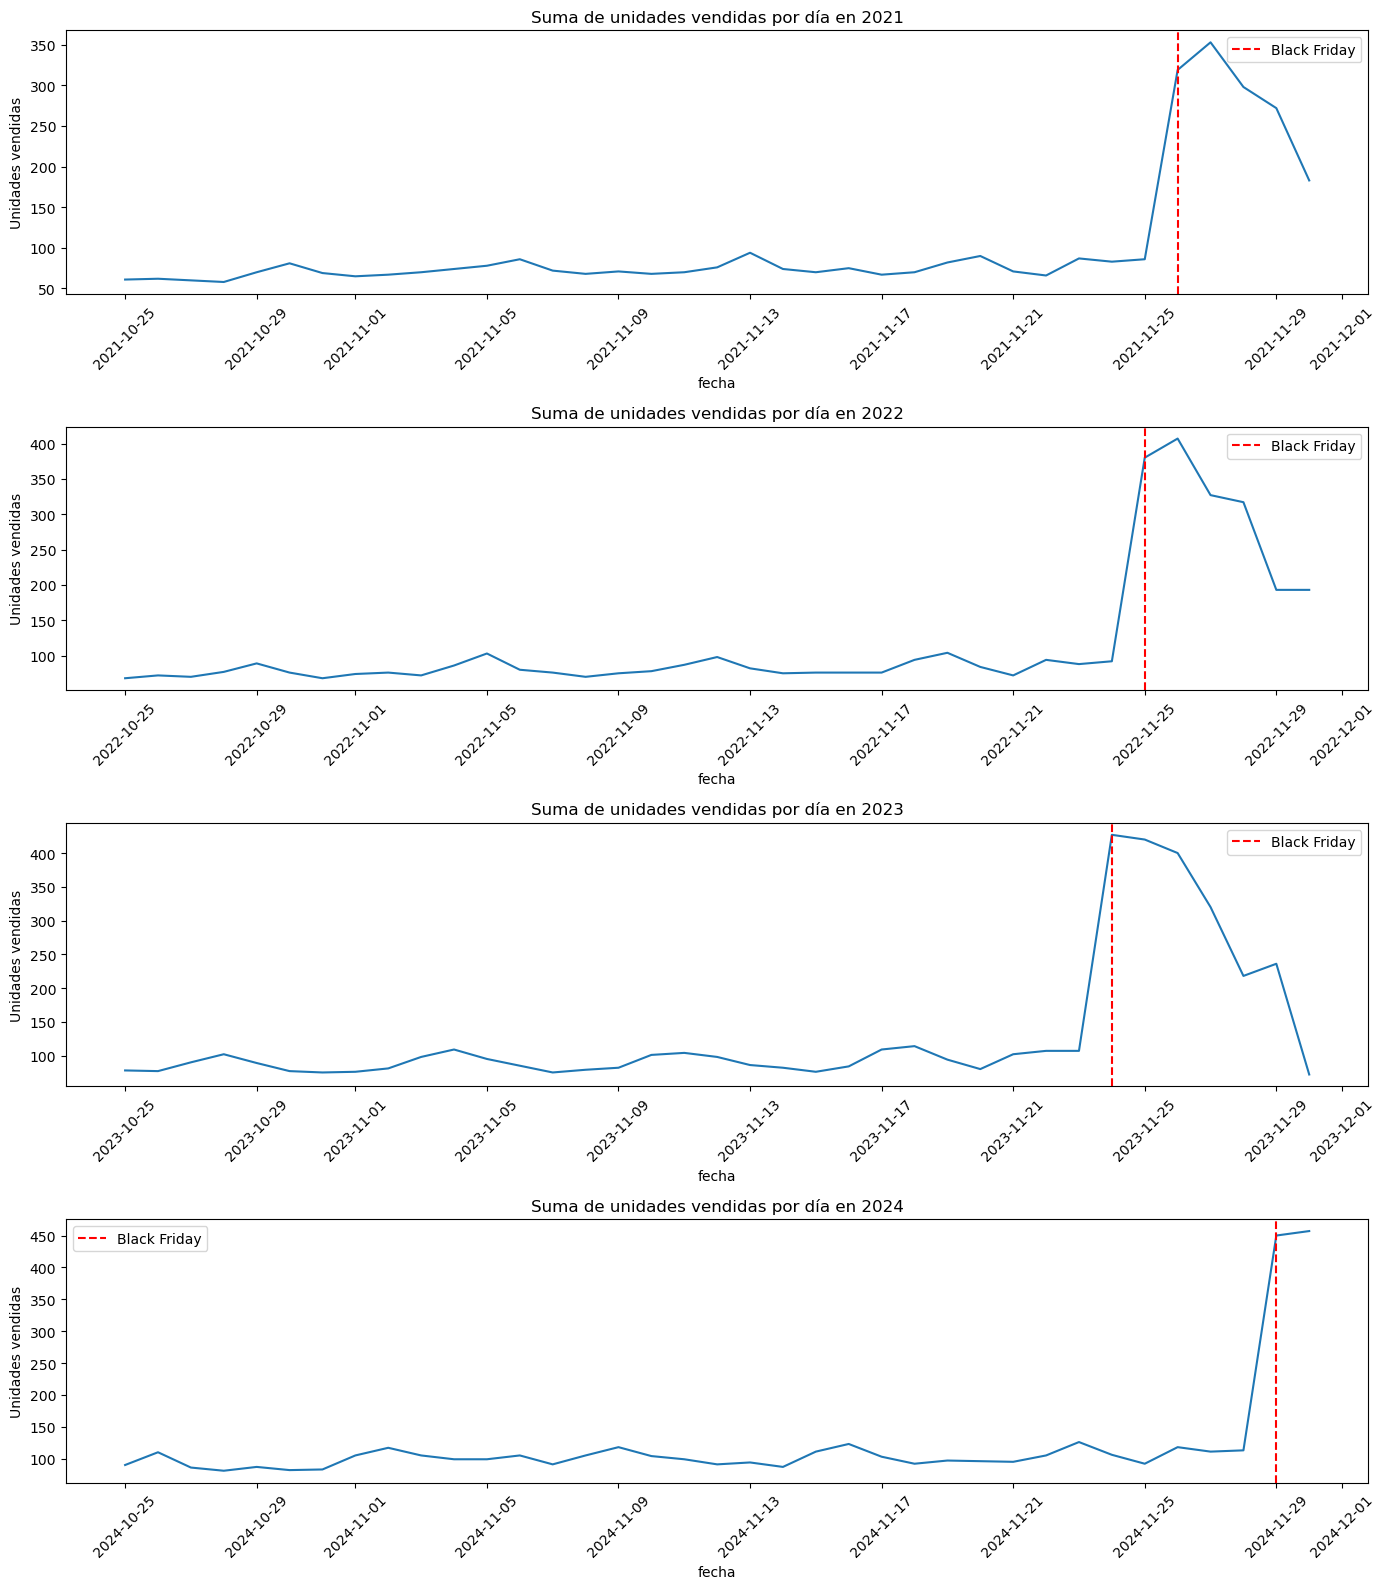

In [99]:
# Gráfico de líneas temporales por año con suma de unidades vendidas y marcando Black Fridays

# Aseguramos que la columna fecha sea datetime
df['fecha'] = pd.to_datetime(df['fecha'])

# Identificamos los años presentes
years = df['fecha'].dt.year.unique()

# Función para obtener Black Friday (último viernes de noviembre)
def get_black_friday(year):
    nov = pd.date_range(start=f'{year}-11-01', end=f'{year}-11-30', freq='D')
    return nov[nov.weekday == 4][-1]

black_fridays = {year: get_black_friday(year) for year in years}

# Crear subplots
fig, axes = plt.subplots(len(years), 1, figsize=(14, 4*len(years)), sharex=False)
if len(years) == 1:
    axes = [axes]

for i, year in enumerate(sorted(years)):
    data = df[df['fecha'].dt.year == year]
    daily = data.groupby('fecha')['unidades_vendidas'].sum()
    sns.lineplot(x=daily.index, y=daily.values, ax=axes[i])
    axes[i].axvline(black_fridays[year], color='red', linestyle='--', label='Black Friday')
    axes[i].set_title(f'Suma de unidades vendidas por día en {year}')
    axes[i].set_ylabel('Unidades vendidas')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend()

plt.tight_layout()
plt.show()


### 3.2 Ventas por día de la semana


C:\Users\acast\AppData\Local\Temp\ipykernel_1108\3205152172.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=semana.index, y=semana.values, palette='viridis')


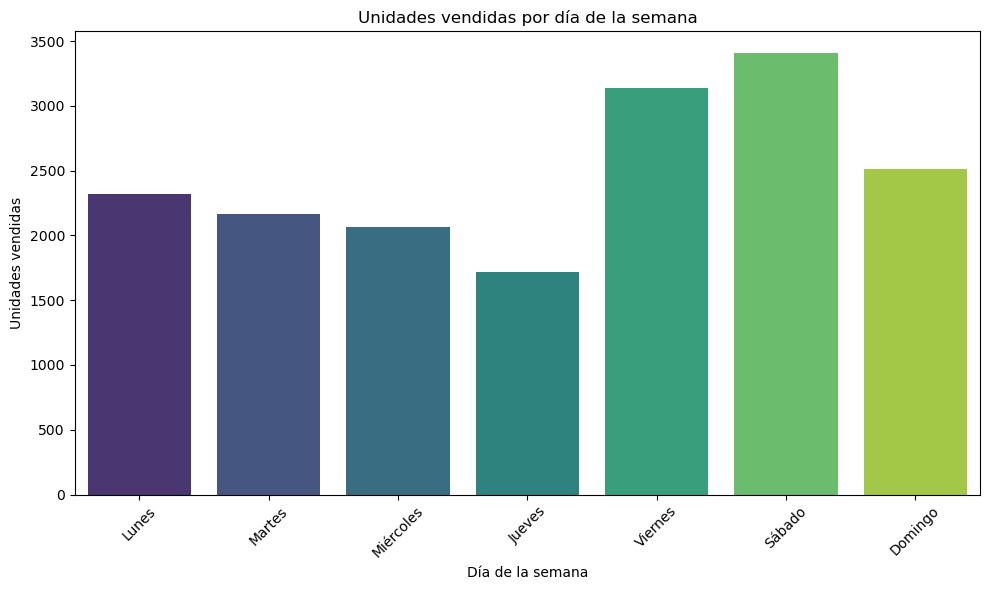

In [100]:
# Suma de unidades vendidas por día de la semana
dias_orden_es = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

# Crear columna con día de la semana
df['dia_semana_nombre'] = df['fecha'].dt.dayofweek.map(dict(zip(range(7), dias_orden_es)))

semana = df.groupby('dia_semana_nombre')['unidades_vendidas'].sum().reindex(dias_orden_es)

plt.figure(figsize=(10,6))
sns.barplot(x=semana.index, y=semana.values, palette='viridis')
plt.title('Unidades vendidas por día de la semana')
plt.ylabel('Unidades vendidas')
plt.xlabel('Día de la semana')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 3.3 Ventas por categoría


C:\Users\acast\AppData\Local\Temp\ipykernel_1108\874809626.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cat.index, y=cat.values, palette='crest')


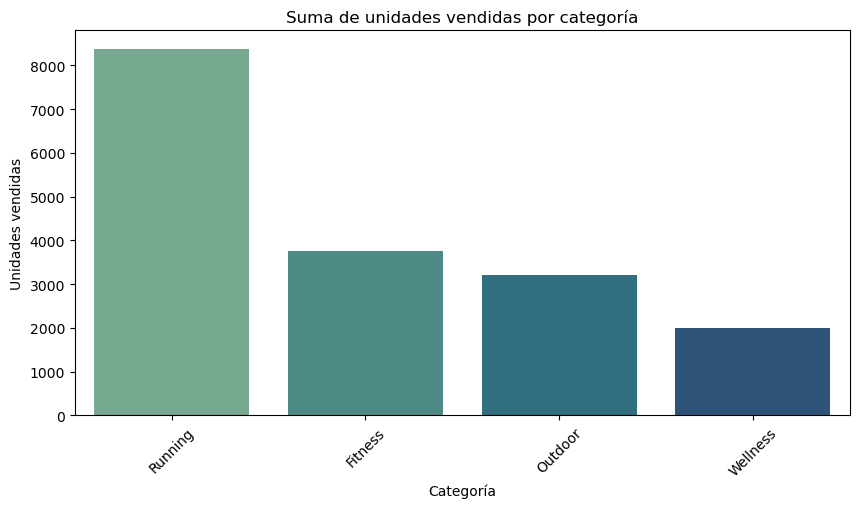

In [101]:
# Suma de unidades vendidas por categoría
cat = df.groupby('categoria')['unidades_vendidas'].sum().sort_values(ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x=cat.index, y=cat.values, palette='crest')
plt.title('Suma de unidades vendidas por categoría')
plt.ylabel('Unidades vendidas')
plt.xlabel('Categoría')
plt.xticks(rotation=45)
plt.show()

### 3.4 Ventas por subcategoría


C:\Users\acast\AppData\Local\Temp\ipykernel_1108\1073307213.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=subcat.index, y=subcat.values, palette='mako')


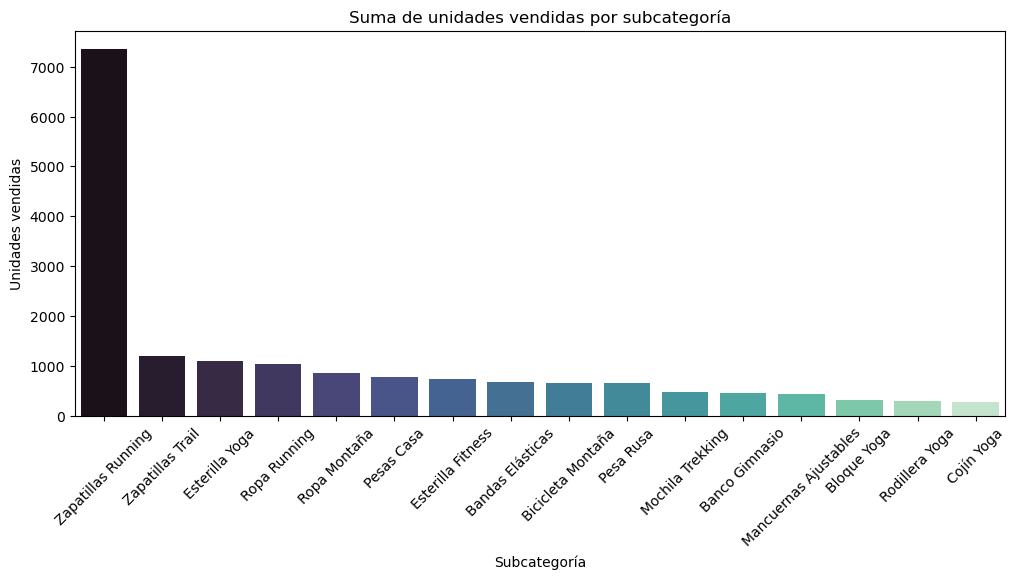

In [102]:
# Suma de unidades vendidas por subcategoría
subcat = df.groupby('subcategoria')['unidades_vendidas'].sum().sort_values(ascending=False)
plt.figure(figsize=(12,5))
sns.barplot(x=subcat.index, y=subcat.values, palette='mako')
plt.title('Suma de unidades vendidas por subcategoría')
plt.ylabel('Unidades vendidas')
plt.xlabel('Subcategoría')
plt.xticks(rotation=45)
plt.show()

### 3.5 Top 15 productos más vendidos


C:\Users\acast\AppData\Local\Temp\ipykernel_1108\2568446256.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_prod.index, x=top_prod.values, palette='flare')


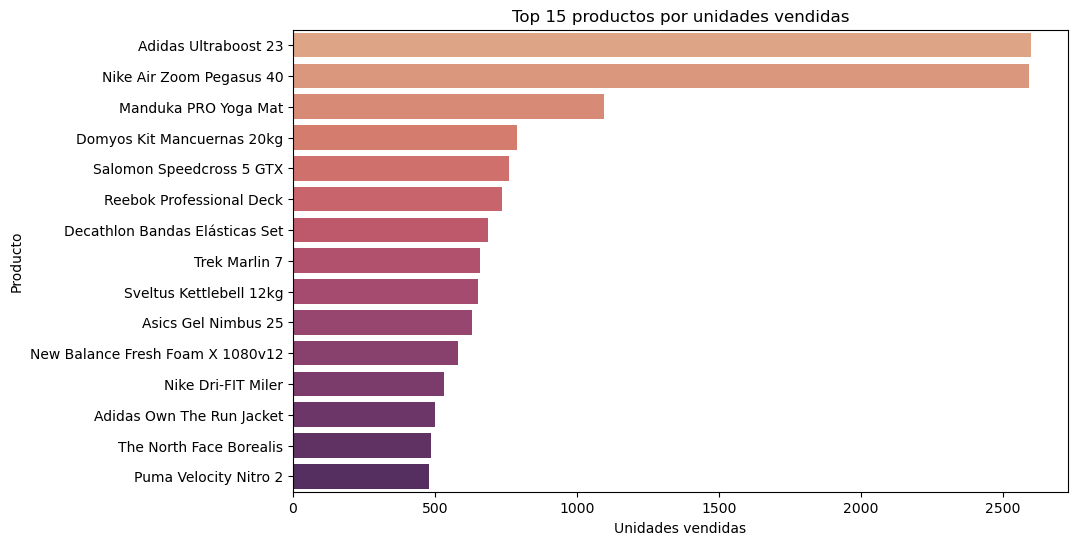

In [103]:
# Top productos por unidades vendidas
top_n = 15
top_prod = df.groupby('nombre')['unidades_vendidas'].sum().sort_values(ascending=False).head(top_n)
plt.figure(figsize=(10,6))
sns.barplot(y=top_prod.index, x=top_prod.values, palette='flare')
plt.title(f'Top {top_n} productos por unidades vendidas')
plt.xlabel('Unidades vendidas')
plt.ylabel('Producto')
plt.show()

### 3.6 Comparación de precios vs competencia (Amazon)


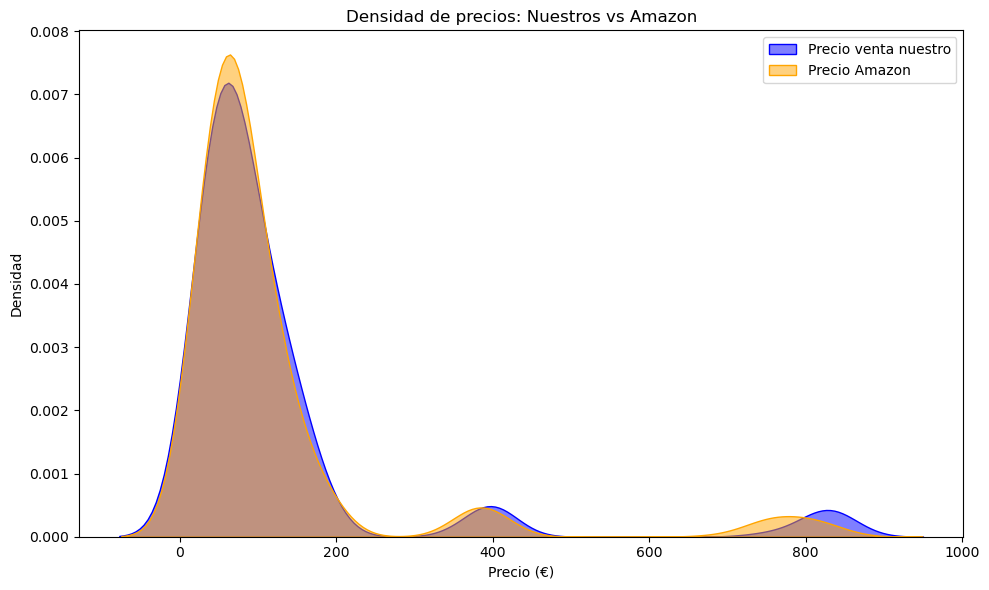

In [104]:
# Análisis de densidad de precios: nuestros vs Amazon
plt.figure(figsize=(10,6))
sns.kdeplot(df['precio_venta'], label='Precio venta nuestro', fill=True, color='blue', alpha=0.5)
sns.kdeplot(df['Amazon'], label='Precio Amazon', fill=True, color='orange', alpha=0.5)
plt.title('Densidad de precios: Nuestros vs Amazon')
plt.xlabel('Precio (€)')
plt.ylabel('Densidad')
plt.legend()
plt.tight_layout()
plt.show()


---

## 4️⃣ Ingeniería de Features

Creamos variables adicionales para mejorar el poder predictivo del modelo.


### 4.1 Variables temporales y de calendario


In [105]:
# Variables temporales y de calendario usando holidays para España

# Asegurarse de que la columna 'fecha' es datetime
if not np.issubdtype(df['fecha'].dtype, np.datetime64):
    df['fecha'] = pd.to_datetime(df['fecha'])

# Variables básicas de fecha
df['año'] = df['fecha'].dt.year
df['mes'] = df['fecha'].dt.month
df['dia_mes'] = df['fecha'].dt.day
df['dia_semana'] = df['fecha'].dt.weekday  # 0=Lunes, 6=Domingo

# Nombre del día
try:
    df['nombre_dia'] = df['fecha'].dt.day_name(locale='es_ES')
except:
    df['nombre_dia'] = df['fecha'].dt.day_name()

# Es fin de semana
df['es_fin_de_semana'] = df['dia_semana'].isin([5, 6]).astype(int)

# Festivos en España
festivos_es = holidays.country_holidays('ES', years=df['año'].unique())
festivos_ts = set([pd.Timestamp(f) for f in festivos_es])
df['es_festivo'] = df['fecha'].isin(festivos_ts).astype(int)

# Black Friday (último viernes de noviembre)
def es_black_friday(fecha):
    if fecha.month == 11:
        ultimo_viernes = max(
            day for day in range(24, 31)
            if pd.Timestamp(year=fecha.year, month=11, day=day).weekday() == 4
        )
        return int(fecha.day == ultimo_viernes)
    return 0

df['es_blackfriday'] = df['fecha'].apply(es_black_friday)

# Cyber Monday (lunes siguiente a Black Friday)
def es_cyber_monday(fecha):
    if fecha.month == 11 or (fecha.month == 12 and fecha.day <= 3):
        ultimo_viernes = max(
            day for day in range(24, 31)
            if pd.Timestamp(year=fecha.year, month=11, day=day).weekday() == 4
        )
        black_friday = pd.Timestamp(year=fecha.year, month=11, day=ultimo_viernes)
        cyber_monday = black_friday + pd.Timedelta(days=3)
        return int(fecha == cyber_monday)
    return 0

df['es_cybermonday'] = df['fecha'].apply(es_cyber_monday)

# Semana del año, inicio y fin de mes, trimestre
df['semana_del_año'] = df['fecha'].dt.isocalendar().week
df['inicio_mes'] = (df['dia_mes'] == 1).astype(int)
df['fin_mes'] = (df['fecha'] == df['fecha'] + pd.offsets.MonthEnd(0)).astype(int)
df['trimestre'] = df['fecha'].dt.quarter

# Días hasta el siguiente festivo
def dias_hasta_festivo(fecha):
    futuros = [f for f in festivos_ts if f >= fecha]
    if futuros:
        return min([(f - fecha).days for f in futuros])
    return np.nan

df['dias_hasta_festivo'] = df['fecha'].apply(dias_hasta_festivo)

# Es víspera de festivo
df['es_vispera_festivo'] = df['fecha'].apply(lambda x: int((x + pd.Timedelta(days=1)) in festivos_ts))

# Mitad de mes (días 13-18)
df['es_mitad_mes'] = df['dia_mes'].between(13, 18).astype(int)

print('✓ Variables temporales y de calendario creadas')
print(f'✓ Nuevas columnas: año, mes, dia_mes, dia_semana, es_fin_de_semana, es_festivo, es_blackfriday, es_cybermonday, etc.')


✓ Variables temporales y de calendario creadas
✓ Nuevas columnas: año, mes, dia_mes, dia_semana, es_fin_de_semana, es_festivo, es_blackfriday, es_cybermonday, etc.


### 4.2 Variables de Lags y Media Móvil


In [106]:
# Lags y media móvil de unidades vendidas por producto y año

def crear_lags_y_media(df, col_lag='unidades_vendidas', lags=7, window=7):
    """
    Crea variables lag (1 a 7 días) y media móvil de 7 días.
    Se calcula por producto y año para evitar contaminar entre periodos.
    """
    df = df.sort_values(['producto_id', 'año', 'fecha']).copy()
    
    # Crear lags de 1 a 7 días
    for i in range(1, lags+1):
        df[f'lag_{i}'] = df.groupby(['producto_id', 'año'])[col_lag].shift(i)
    
    # Media móvil de 7 días (desplazada 1 día para evitar data leakage)
    df['media_movil_7d'] = df.groupby(['producto_id', 'año'])[col_lag].transform(
        lambda x: x.rolling(window, min_periods=1).mean().shift(1)
    )
    
    return df

# Aplicar la función
df = crear_lags_y_media(df)

# Eliminar registros con nulos en lags o media móvil
lag_cols = [f'lag_{i}' for i in range(1, 8)] + ['media_movil_7d']
filas_antes = len(df)
df = df.dropna(subset=lag_cols).reset_index(drop=True)
filas_despues = len(df)

print(f'✓ Variables lag y media móvil creadas')
print(f'✓ Filas eliminadas por nulos en lags: {filas_antes - filas_despues}')
print(f'✓ Filas restantes: {filas_despues}')


✓ Variables lag y media móvil creadas
✓ Filas eliminadas por nulos en lags: 672
✓ Filas restantes: 2880


### 4.3 Variables de Precios y Competencia


In [107]:
# Variable de descuento porcentaje
df['descuento_pct'] = ((df['precio_venta'] - df['precio_base']) / df['precio_base']) * 100

print('✓ Variable descuento_pct creada')


✓ Variable descuento_pct creada


In [108]:
# Precio promedio de la competencia y ratio de precios
compet_cols = ['Amazon', 'Decathlon', 'Deporvillage']

# Precio promedio de Amazon, Decathlon y Deporvillage
df['precio_competencia'] = df[compet_cols].mean(axis=1)

# Ratio: nuestro precio vs competencia
df['ratio_Precio'] = df['precio_venta'] / df['precio_competencia']

# Eliminar columnas individuales de competidores
df = df.drop(columns=compet_cols)

print('✓ Variables precio_competencia y ratio_Precio creadas')
print('✓ Columnas de competidores individuales eliminadas')


✓ Variables precio_competencia y ratio_Precio creadas
✓ Columnas de competidores individuales eliminadas


### 4.4 Encoding de Variables Categóricas (One-Hot Encoding)


In [109]:
# One-Hot Encoding para variables categóricas
# Guardamos las columnas originales antes de codificar para referencia posterior

# Guardar información de identificación antes del encoding
df['nombre_producto'] = df['nombre']
df['categoria_producto'] = df['categoria']
df['subcategoria_producto'] = df['subcategoria']

# Aplicar OneHot Encoding
df_encoded = pd.get_dummies(df, columns=['nombre', 'categoria', 'subcategoria'], 
                              prefix=['nombre', 'categoria', 'subcategoria'])

print(f'✓ One-Hot Encoding aplicado')
print(f'✓ Forma del dataframe: {df_encoded.shape[0]} filas, {df_encoded.shape[1]} columnas')
print(f'✓ Columnas categóricas codificadas: nombre, categoria, subcategoria')
print(f'✓ Columnas de referencia mantenidas: nombre_producto, categoria_producto, subcategoria_producto')


✓ One-Hot Encoding aplicado
✓ Forma del dataframe: 2880 filas, 82 columnas
✓ Columnas categóricas codificadas: nombre, categoria, subcategoria
✓ Columnas de referencia mantenidas: nombre_producto, categoria_producto, subcategoria_producto


### 4.5 Guardar Dataset Procesado


In [110]:
# Guardar dataset procesado
output_path = '../data/processed/df.csv'
df_encoded.to_csv(output_path, index=False)

print(f'✓ Dataset procesado guardado en: {output_path}')


✓ Dataset procesado guardado en: ../data/processed/df.csv


---

## 5️⃣ Preparación de Datos para Modelado

Dividimos los datos en conjuntos de entrenamiento y validación.


In [111]:
# Usar el dataset con encoding
df = df_encoded.copy()

# Dividir en train (2021-2023) y validation (2024)
train_df = df[df['año'].isin([2021, 2022, 2023])].copy()
validation_df = df[df['año'] == 2024].copy()

print('='*50)
print('📊 DIVISIÓN DE DATOS')
print('='*50)
print(f'✓ Entrenamiento (2021-2023): {len(train_df):,} registros')
print(f'✓ Validación (2024): {len(validation_df):,} registros')
print(f'✓ Total: {len(df):,} registros')
print(f'✓ Proporción train/val: {len(train_df)/len(df)*100:.1f}% / {len(validation_df)/len(df)*100:.1f}%')


📊 DIVISIÓN DE DATOS
✓ Entrenamiento (2021-2023): 2,160 registros
✓ Validación (2024): 720 registros
✓ Total: 2,880 registros
✓ Proporción train/val: 75.0% / 25.0%


---

## 6️⃣ Entrenamiento y Evaluación del Modelo

Entrenamos un modelo HistGradientBoostingRegressor y evaluamos su rendimiento.


### 6.1 Entrenamiento del modelo y métricas


In [112]:
# Entrenamiento de HistGradientBoostingRegressor y comparación con baseline

# Selección de variables predictoras y target
target = 'unidades_vendidas'
drop_cols = ['fecha', 'ingresos', 'nombre_producto', 'categoria_producto', 'subcategoria_producto', 'nombre_dia']
X_cols = [col for col in train_df.columns if col not in drop_cols + [target] and train_df[col].dtype != 'O']

X_train = train_df[X_cols]
y_train = train_df[target]
X_val = validation_df[X_cols]
y_val = validation_df[target]

print(f'✓ Variables predictoras: {len(X_cols)}')
print(f'✓ Train: {X_train.shape}')
print(f'✓ Validation: {X_val.shape}')
print('\n🤖 Entrenando modelo...\n')

# Modelo conservador para evitar overfitting
model = HistGradientBoostingRegressor(
    learning_rate=0.03,
    max_iter=400,
    max_depth=7,
    l2_regularization=1.0,
    early_stopping=True,
    random_state=42
)
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_val)

# Baseline naive: predice la media del train
y_pred_naive = np.full_like(y_val, y_train.mean(), dtype=float)

# Métricas del modelo
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# Métricas del baseline
mae_naive = mean_absolute_error(y_val, y_pred_naive)
mse_naive = mean_squared_error(y_val, y_pred_naive)
rmse_naive = np.sqrt(mse_naive)
mape_naive = mean_absolute_percentage_error(y_val, y_pred_naive)
r2_naive = r2_score(y_val, y_pred_naive)

print('='*60)
print('📊 MÉTRICAS DE EVALUACIÓN')
print('='*60)
print('\n🚀 HistGradientBoostingRegressor:')
print(f'  MAE:  {mae:.2f} unidades')
print(f'  RMSE: {rmse:.2f} unidades')
print(f'  MAPE: {mape:.2%}')
print(f'  R²:   {r2:.4f}')

print('\n📉 Baseline Naive (media):')
print(f'  MAE:  {mae_naive:.2f} unidades')
print(f'  RMSE: {rmse_naive:.2f} unidades')
print(f'  MAPE: {mape_naive:.2%}')
print(f'  R²:   {r2_naive:.4f}')

print('\n💡 Mejora respecto al baseline:')
print(f'  MAE:  {(1 - mae/mae_naive)*100:.1f}% mejor')
print(f'  RMSE: {(1 - rmse/rmse_naive)*100:.1f}% mejor')
print(f'  MAPE: {(1 - mape/mape_naive)*100:.1f}% mejor')
print('='*60)


✓ Variables predictoras: 73
✓ Train: (2160, 73)
✓ Validation: (720, 73)

🤖 Entrenando modelo...

📊 MÉTRICAS DE EVALUACIÓN

🚀 HistGradientBoostingRegressor:
  MAE:  1.12 unidades
  RMSE: 2.39 unidades
  MAPE: 19.21%
  R²:   0.8727

📉 Baseline Naive (media):
  MAE:  3.67 unidades
  RMSE: 6.69 unidades
  MAPE: 93.02%
  R²:   -0.0001

💡 Mejora respecto al baseline:
  MAE:  69.5% mejor
  RMSE: 64.3% mejor
  MAPE: 79.3% mejor


---

## 7️⃣ Validación en Noviembre 2024

Análisis detallado del rendimiento del modelo en noviembre 2024.


### 7.1 Predicciones para productos estrella en noviembre 2024


In [113]:
df_nov2024

,fecha,producto_id,precio_base,es_estrella,unidades_vendidas,precio_venta,ingresos,dia_semana_nombre,año,mes,...,subcategoria_Esterilla Yoga,subcategoria_Mancuernas Ajustables,subcategoria_Mochila Trekking,subcategoria_Pesa Rusa,subcategoria_Pesas Casa,subcategoria_Rodillera Yoga,subcategoria_Ropa Montaña,subcategoria_Ropa Running,subcategoria_Zapatillas Running,subcategoria_Zapatillas Trail
90,2024-11-01,PROD_001,115,True,15,118.32,1774.80,Viernes,2024,11,...,False,False,False,False,False,False,False,False,True,False
91,2024-11-02,PROD_001,115,True,21,113.69,2387.49,Sábado,2024,11,...,False,False,False,False,False,False,False,False,True,False
92,2024-11-03,PROD_001,115,True,16,116.76,1868.16,Domingo,2024,11,...,False,False,False,False,False,False,False,False,True,False
93,2024-11-04,PROD_001,115,True,14,115.15,1612.10,Lunes,2024,11,...,False,False,False,False,False,False,False,False,True,False
94,2024-11-05,PROD_001,115,True,15,115.84,1737.60,Martes,2024,11,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2515,2024-11-26,PROD_021,130,True,7,133.78,936.46,Martes,2024,11,...,True,False,False,False,False,False,False,False,False,False
2516,2024-11-27,PROD_021,130,True,9,127.21,1144.89,Miércoles,2024,11,...,True,False,False,False,False,False,False,False,False,False
2517,2024-11-28,PROD_021,130,True,7,131.29,919.03,Jueves,2024,11,...,True,False,False,False,False,False,False,False,False,False
2518,2024-11-29,PROD_021,130,True,27,123.50,3334.50,Viernes,2024,11,...,True,False,False,False,False,False,False,False,False,False


📦 Productos estrella en noviembre 2024: 7

🔮 Generando gráficos de predicción vs realidad...



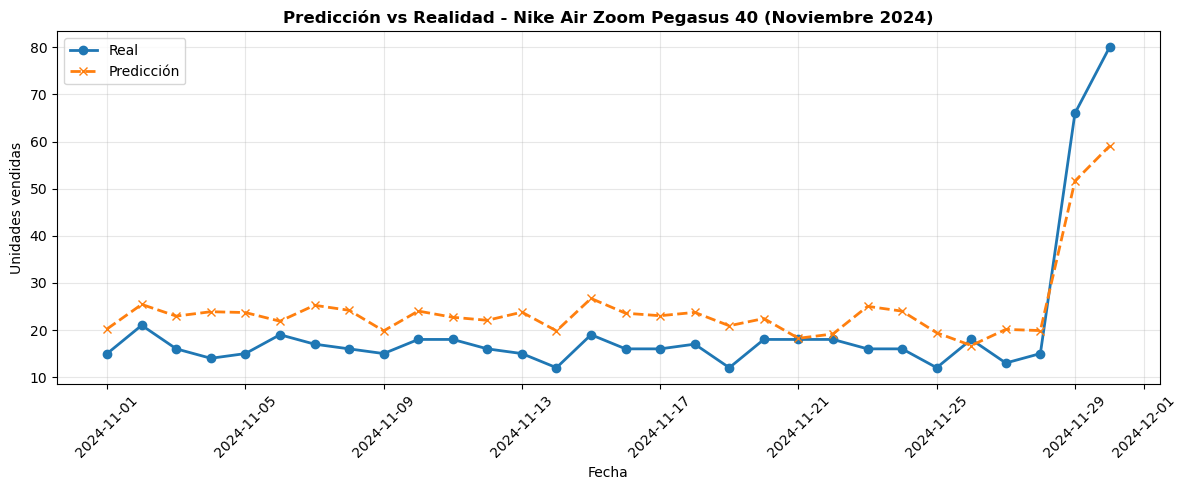

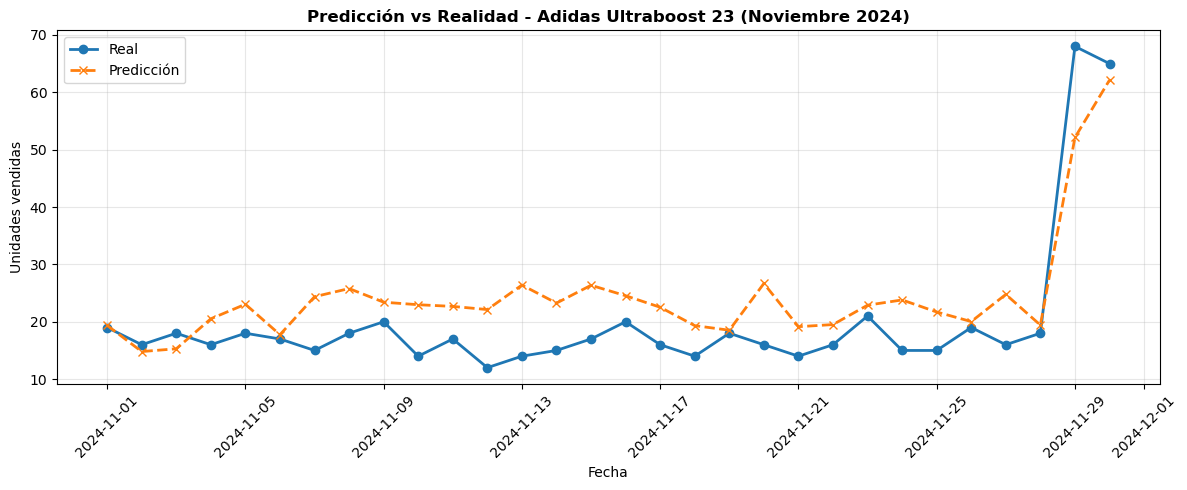

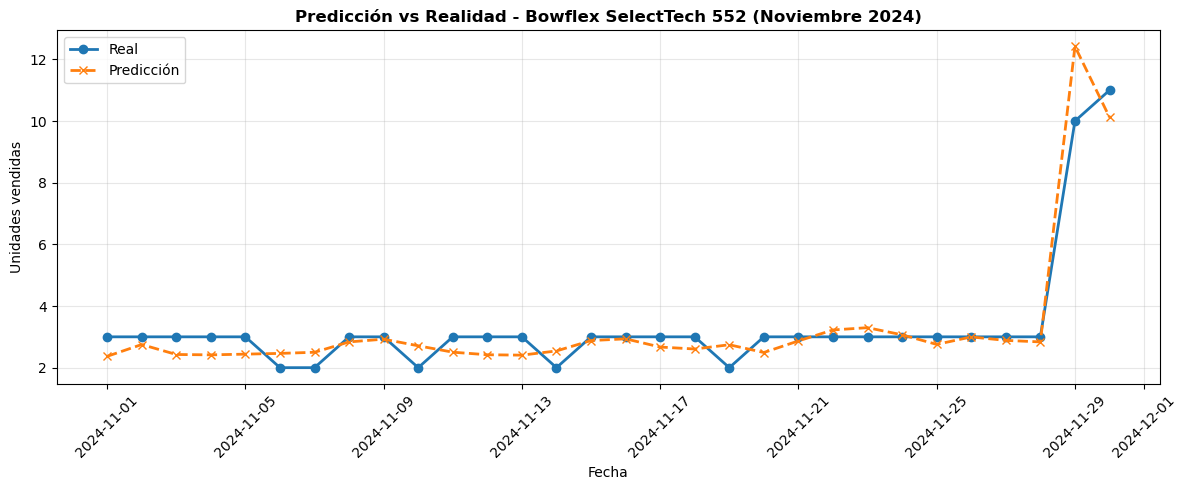

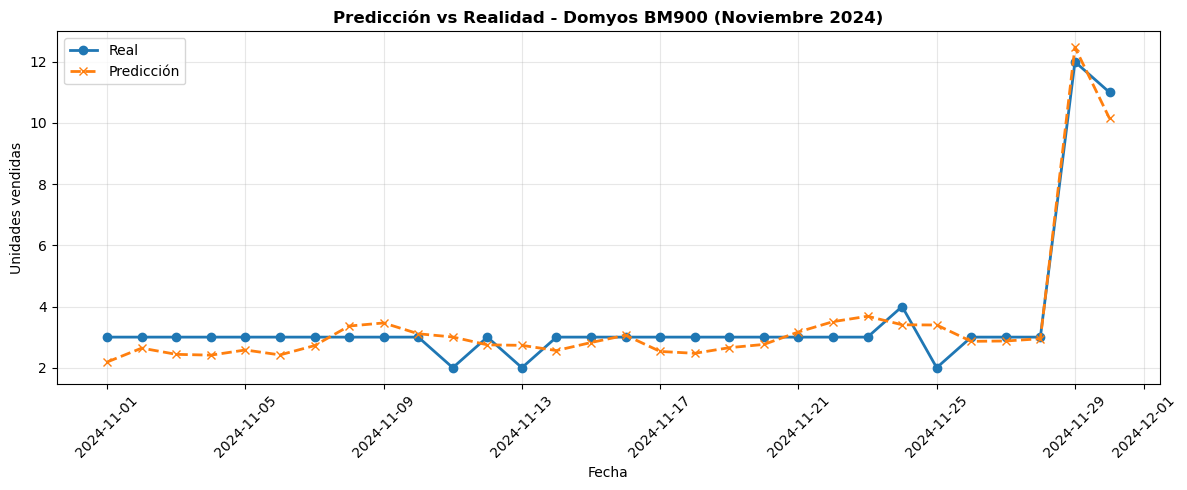

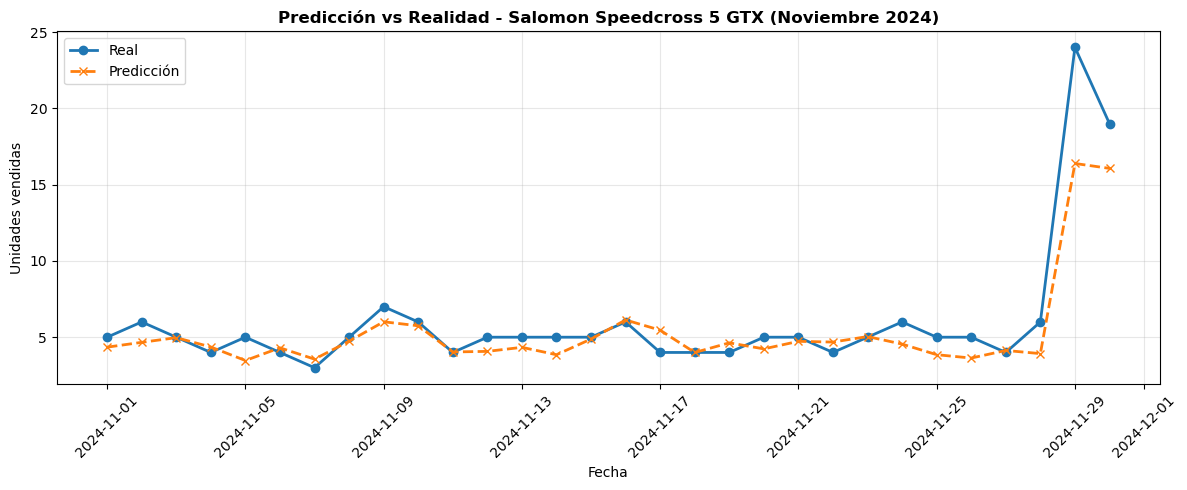

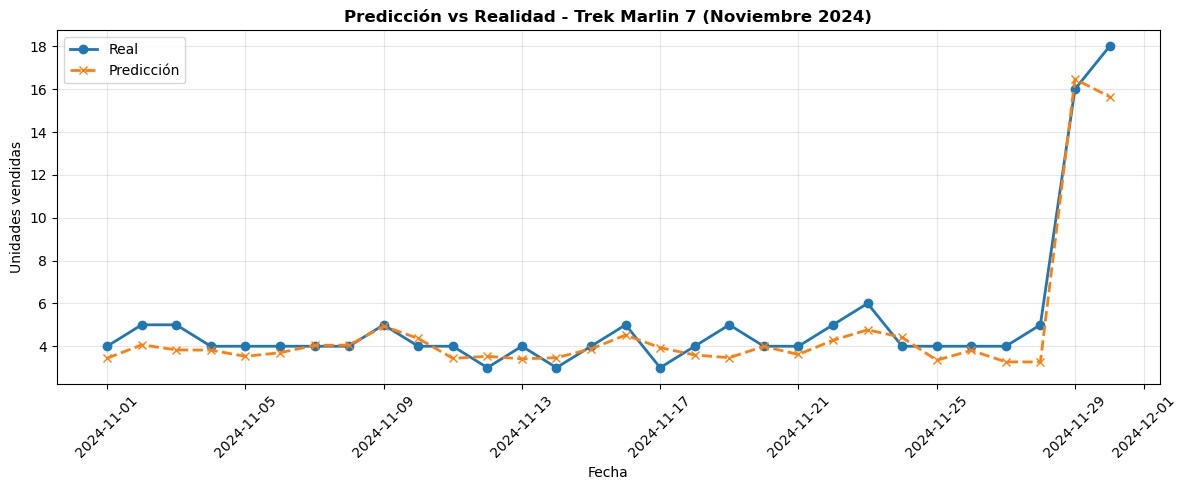

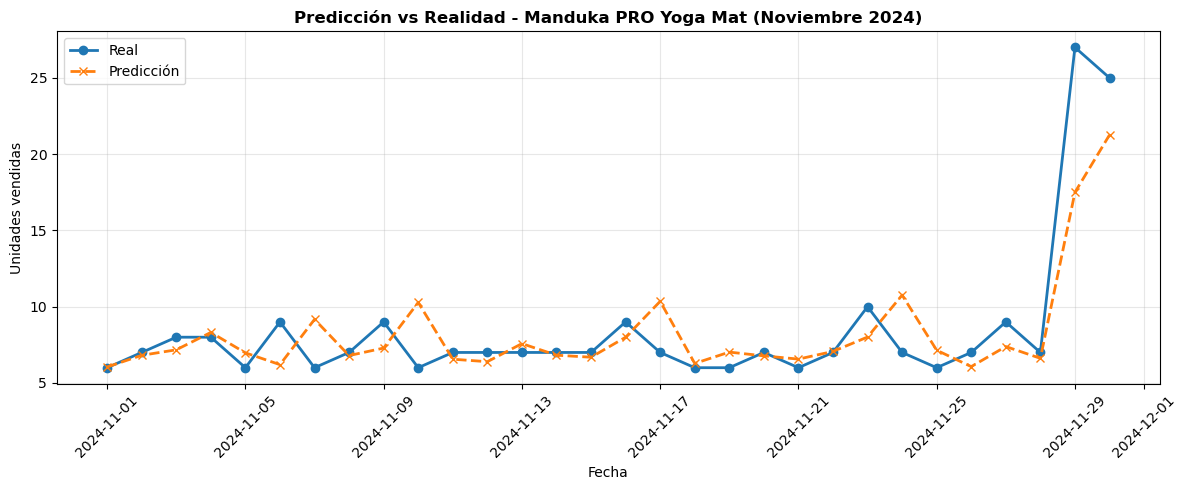

In [114]:
# Predicción para noviembre 2024 de los productos estrella y gráficos comparativos

# Filtrar noviembre 2024 y productos estrella
df_nov2024 = df[(df['año'] == 2024) & (df['mes'] == 11) & (df['es_estrella'] == 1)].copy()
productos_estrella = df_nov2024['nombre_producto'].unique()

print(f'📦 Productos estrella en noviembre 2024: {len(productos_estrella)}')
print('\n🔮 Generando gráficos de predicción vs realidad...\n')

# Seleccionar variables predictoras (excluir columnas de texto)
drop_cols = ['fecha', 'ingresos', 'unidades_vendidas', 'nombre_producto', 'categoria_producto', 'subcategoria_producto', 'nombre_dia']
X_cols = [col for col in df_nov2024.columns if col not in drop_cols and df_nov2024[col].dtype != 'O']

# Generar predicciones y graficar para cada producto estrella
for producto in productos_estrella:
    df_prod = df_nov2024[df_nov2024['nombre_producto'] == producto].copy()
    X_prod = df_prod[X_cols]
    y_real = df_prod['unidades_vendidas']
    fechas = df_prod['fecha']
    y_pred = model.predict(X_prod)
    
    plt.figure(figsize=(12,5))
    plt.plot(fechas, y_real, label='Real', marker='o', linewidth=2)
    plt.plot(fechas, y_pred, label='Predicción', marker='x', linewidth=2, linestyle='--')
    plt.title(f'Predicción vs Realidad - {producto} (Noviembre 2024)', fontsize=12, fontweight='bold')
    plt.xlabel('Fecha')
    plt.ylabel('Unidades vendidas')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


### 7.2 MAE por producto estrella


In [115]:
# Calcular el MAE para cada producto estrella

mae_productos = []
for producto in productos_estrella:
    df_prod = df_nov2024[df_nov2024['nombre_producto'] == producto].copy()
    X_prod = df_prod[X_cols]
    y_real = df_prod['unidades_vendidas']
    y_pred = model.predict(X_prod)
    mae = mean_absolute_error(y_real, y_pred)
    mae_productos.append({'producto': producto, 'MAE': mae})

mae_df = pd.DataFrame(mae_productos).sort_values('MAE')

print('='*60)
print('📊 MAE POR PRODUCTO ESTRELLA (ordenado de mejor a peor)')
print('='*60)
print(mae_df.to_string(index=False))
print('='*60)


📊 MAE POR PRODUCTO ESTRELLA (ordenado de mejor a peor)
                producto      MAE
  Bowflex SelectTech 552 0.447860
            Domyos BM900 0.459225
           Trek Marlin 7 0.622157
Salomon Speedcross 5 GTX 0.996006
    Manduka PRO Yoga Mat 1.540573
    Adidas Ultraboost 23 5.785961
Nike Air Zoom Pegasus 40 6.988123


### 7.3 Evolución del error a lo largo del mes


📊 MÉTRICAS POR PRODUCTO Y PERIODO EN NOVIEMBRE 2024

Nike Air Zoom Pegasus 40:
periodo     MAE     RMSE  n
   1-10 6.53804 6.870026 10
  11-20 6.97592 7.125374 10
  21-30 7.45041 9.614369 10

Adidas Ultraboost 23:
periodo      MAE     RMSE  n
   1-10 4.412864 5.440410 10
  11-20 7.342090 8.063387 10
  21-30 5.602930 7.107746 10

Bowflex SelectTech 552:
periodo      MAE     RMSE  n
   1-10 0.451212 0.494589 10
  11-20 0.437951 0.482582 10
  21-30 0.454417 0.830231 10

Domyos BM900:
periodo      MAE     RMSE  n
   1-10 0.454037 0.490442 10
  11-20 0.424661 0.500850 10
  21-30 0.498976 0.635490 10

Salomon Speedcross 5 GTX:
periodo      MAE     RMSE  n
   1-10 0.627813 0.787452 10
  11-20 0.588785 0.759844 10
  21-30 1.771420 2.769768 10

Trek Marlin 7:
periodo      MAE     RMSE  n
   1-10 0.414264 0.551572 10
  11-20 0.563493 0.692918 10
  21-30 0.888713 1.099935 10

Manduka PRO Yoga Mat:
periodo      MAE     RMSE  n
   1-10 1.451379 2.023213 10
  11-20 0.800393 1.201918 10
  21-30 2.369

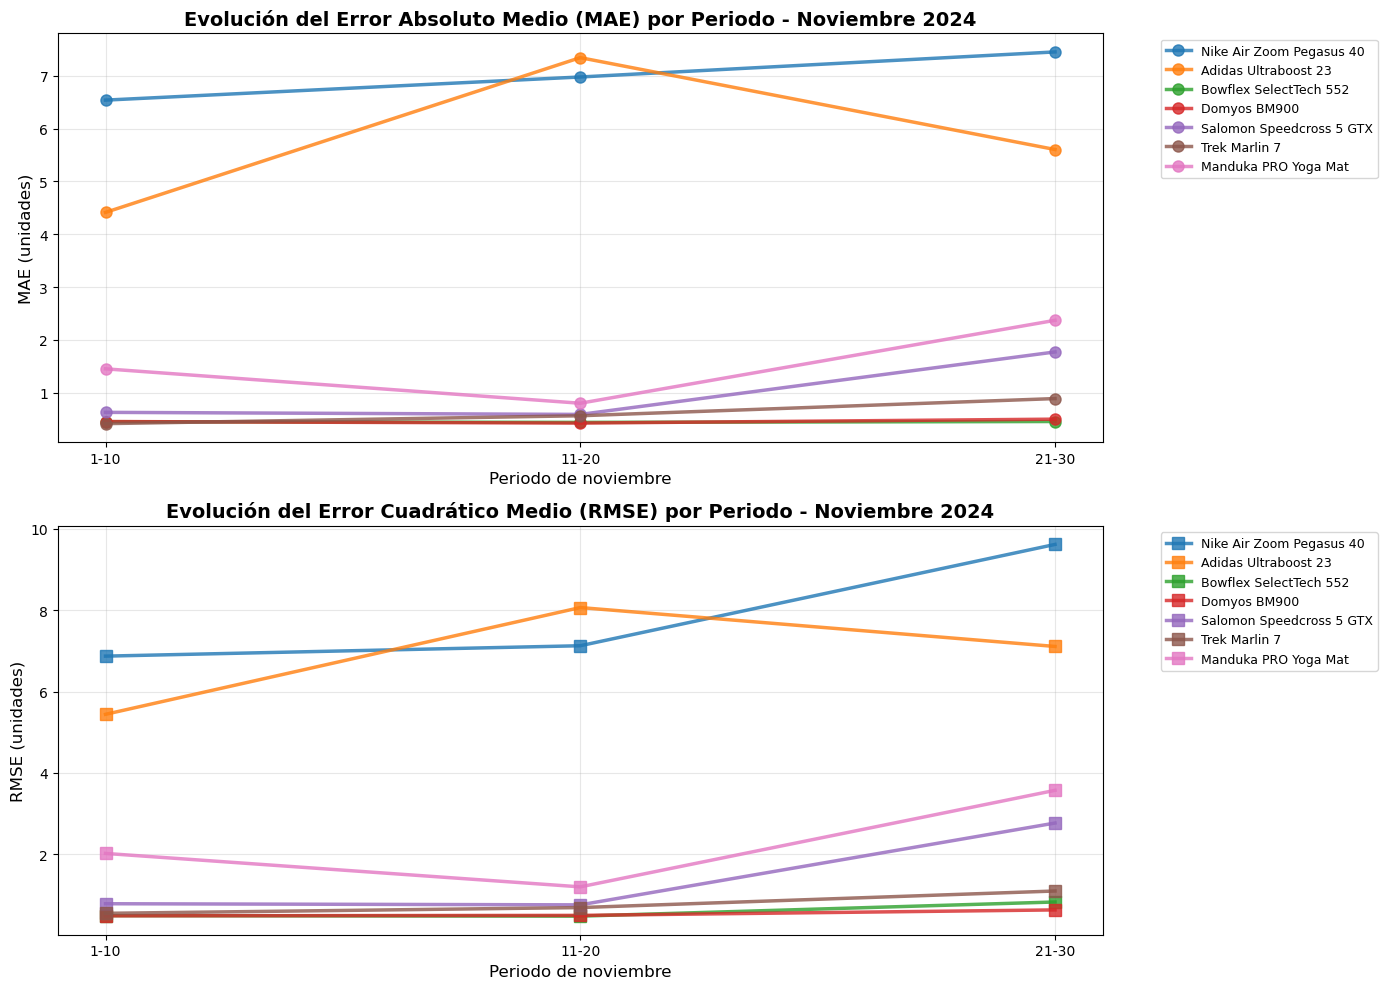

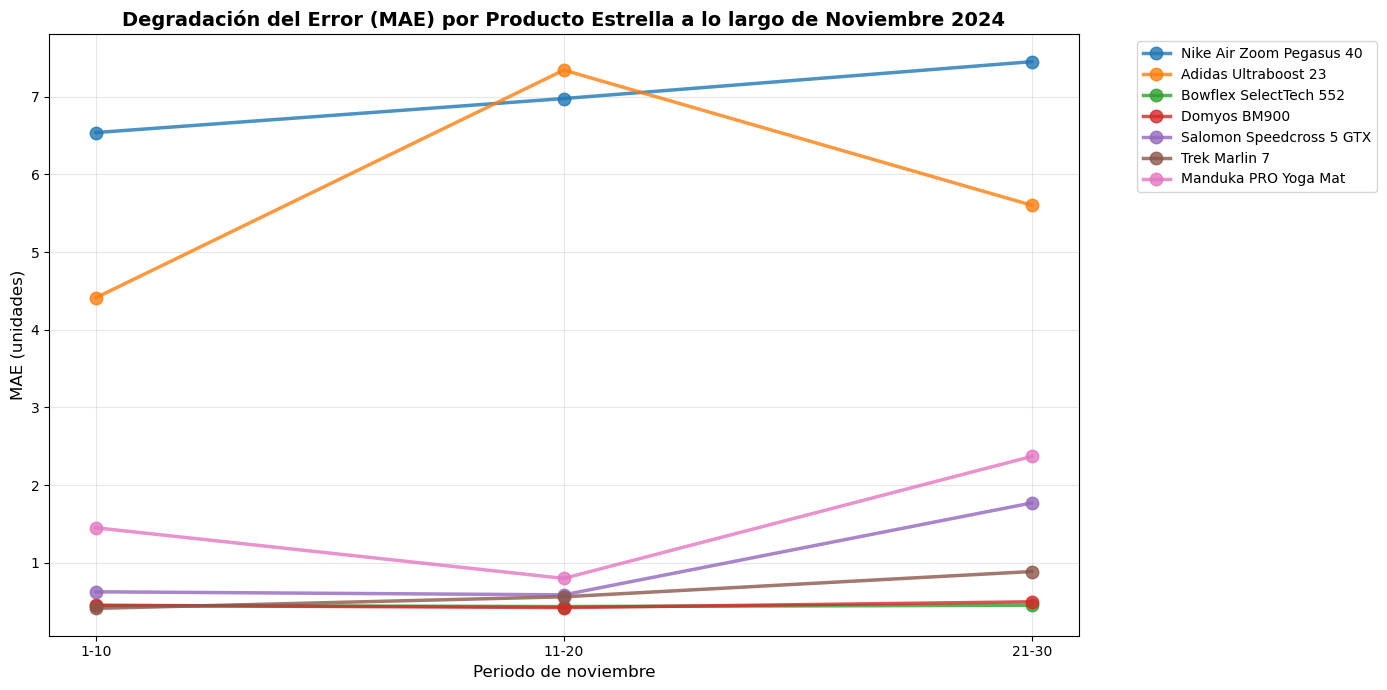


📈 ANÁLISIS DE DEGRADACIÓN DEL ERROR
Nike Air Zoom Pegasus 40:
  MAE inicial (1-10): 6.54
  MAE final (21-30): 7.45
  Degradación: +0.91 (+14.0%)

Adidas Ultraboost 23:
  MAE inicial (1-10): 4.41
  MAE final (21-30): 5.60
  Degradación: +1.19 (+27.0%)

Bowflex SelectTech 552:
  MAE inicial (1-10): 0.45
  MAE final (21-30): 0.45
  Degradación: +0.00 (+0.7%)

Domyos BM900:
  MAE inicial (1-10): 0.45
  MAE final (21-30): 0.50
  Degradación: +0.04 (+9.9%)

Salomon Speedcross 5 GTX:
  MAE inicial (1-10): 0.63
  MAE final (21-30): 1.77
  Degradación: +1.14 (+182.2%)

Trek Marlin 7:
  MAE inicial (1-10): 0.41
  MAE final (21-30): 0.89
  Degradación: +0.47 (+114.5%)

Manduka PRO Yoga Mat:
  MAE inicial (1-10): 1.45
  MAE final (21-30): 2.37
  Degradación: +0.92 (+63.3%)



In [121]:
# Análisis del error por producto estrella en noviembre 2024

# Añadir columna de periodo (1: 1-10, 2: 11-20, 3: 21-30)
df_nov2024['periodo'] = pd.cut(df_nov2024['dia_mes'], bins=[0,10,20,31], 
                                labels=['1-10','11-20','21-30'], right=True)

# Calcular predicciones para todo noviembre 2024
y_pred_all = model.predict(df_nov2024[X_cols])
df_nov2024['pred'] = y_pred_all

# Calcular métricas por producto estrella y por periodo
periodos = ['1-10','11-20','21-30']
metricas_por_producto_periodo = []

for producto in productos_estrella:
    df_producto = df_nov2024[df_nov2024['nombre_producto'] == producto]
    for periodo in periodos:
        df_p = df_producto[df_producto['periodo'] == periodo]
        if len(df_p) > 0:
            mae = mean_absolute_error(df_p['unidades_vendidas'], df_p['pred'])
            rmse = np.sqrt(mean_squared_error(df_p['unidades_vendidas'], df_p['pred']))
            metricas_por_producto_periodo.append({
                'producto': producto,
                'periodo': periodo,
                'MAE': mae,
                'RMSE': rmse,
                'n': len(df_p)
            })

metricas_df = pd.DataFrame(metricas_por_producto_periodo)

# Tabla resumen
print('='*80)
print('📊 MÉTRICAS POR PRODUCTO Y PERIODO EN NOVIEMBRE 2024')
print('='*80)
for producto in productos_estrella:
    print(f'\n{producto}:')
    prod_data = metricas_df[metricas_df['producto'] == producto]
    print(prod_data[['periodo', 'MAE', 'RMSE', 'n']].to_string(index=False))
print('='*80)

# Gráfico 1: Evolución del MAE por periodo para cada producto
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# MAE
for producto in productos_estrella:
    prod_data = metricas_df[metricas_df['producto'] == producto].sort_values('periodo')
    axes[0].plot(prod_data['periodo'], prod_data['MAE'], 
                 marker='o', linewidth=2.5, markersize=8, label=producto, alpha=0.8)

axes[0].set_xlabel('Periodo de noviembre', fontsize=12)
axes[0].set_ylabel('MAE (unidades)', fontsize=12)
axes[0].set_title('Evolución del Error Absoluto Medio (MAE) por Periodo - Noviembre 2024', 
                  fontsize=14, fontweight='bold')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[0].grid(True, alpha=0.3)

# RMSE
for producto in productos_estrella:
    prod_data = metricas_df[metricas_df['producto'] == producto].sort_values('periodo')
    axes[1].plot(prod_data['periodo'], prod_data['RMSE'], 
                 marker='s', linewidth=2.5, markersize=8, label=producto, alpha=0.8)

axes[1].set_xlabel('Periodo de noviembre', fontsize=12)
axes[1].set_ylabel('RMSE (unidades)', fontsize=12)
axes[1].set_title('Evolución del Error Cuadrático Medio (RMSE) por Periodo - Noviembre 2024', 
                  fontsize=14, fontweight='bold')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Gráfico 2: Comparación de productos en un solo gráfico
plt.figure(figsize=(14, 7))

for producto in productos_estrella:
    prod_data = metricas_df[metricas_df['producto'] == producto].sort_values('periodo')
    plt.plot(prod_data['periodo'], prod_data['MAE'], 
             marker='o', linewidth=2.5, markersize=9, label=producto, alpha=0.8)

plt.xlabel('Periodo de noviembre', fontsize=12)
plt.ylabel('MAE (unidades)', fontsize=12)
plt.title('Degradación del Error (MAE) por Producto Estrella a lo largo de Noviembre 2024', 
          fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Resumen estadístico: productos con mayor/menor degradación
print('\n' + '='*80)
print('📈 ANÁLISIS DE DEGRADACIÓN DEL ERROR')
print('='*80)
for producto in productos_estrella:
    prod_data = metricas_df[metricas_df['producto'] == producto].sort_values('periodo')
    mae_inicio = prod_data['MAE'].iloc[0]
    mae_fin = prod_data['MAE'].iloc[-1]
    degradacion = mae_fin - mae_inicio
    pct_degradacion = (degradacion / mae_inicio) * 100
    print(f'{producto}:')
    print(f'  MAE inicial (1-10): {mae_inicio:.2f}')
    print(f'  MAE final (21-30): {mae_fin:.2f}')
    print(f'  Degradación: {degradacion:+.2f} ({pct_degradacion:+.1f}%)')
    print()


### 7.4 Análisis específico de Black Friday 2024


🛍️ Black Friday 2024: 7 productos estrella
📊 MAE en Black Friday: 7.25



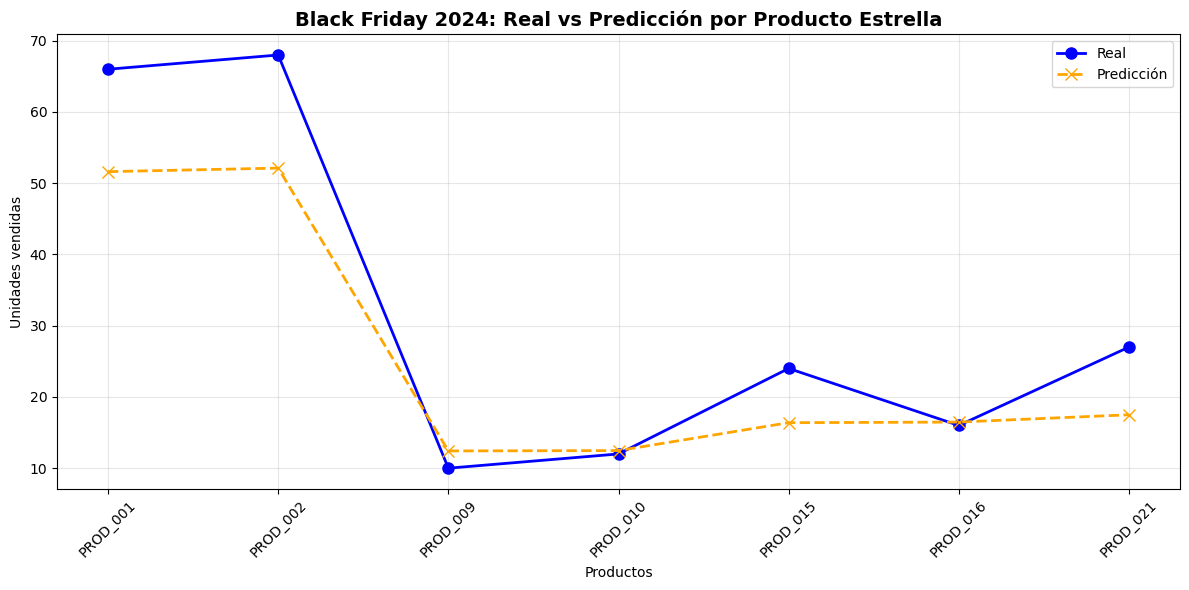

In [117]:
# Análisis específico de Black Friday 2024 para productos estrella

# Filtrar solo el día de Black Friday de 2024
df_bf = df_nov2024[df_nov2024['es_blackfriday'] == 1].copy()

if len(df_bf) > 0:
    # Obtener predicciones para ese día
    y_pred_bf = model.predict(df_bf[X_cols])
    df_bf['pred'] = y_pred_bf
    
    print(f'🛍️ Black Friday 2024: {len(df_bf)} productos estrella')
    print(f'📊 MAE en Black Friday: {mean_absolute_error(df_bf["unidades_vendidas"], df_bf["pred"]):.2f}')
    print()
    
    # Gráfico comparativo
    plt.figure(figsize=(12,6))
    x_pos = range(len(df_bf))
    plt.plot(x_pos, df_bf['unidades_vendidas'].values, label='Real', marker='o', 
             linestyle='-', linewidth=2, markersize=8, color='blue')
    plt.plot(x_pos, df_bf['pred'].values, label='Predicción', marker='x', 
             linestyle='--', linewidth=2, markersize=8, color='orange')
    plt.title('Black Friday 2024: Real vs Predicción por Producto Estrella', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Productos')
    plt.ylabel('Unidades vendidas')
    plt.xticks(x_pos, df_bf['producto_id'].values, rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print('⚠️ No hay datos de Black Friday en noviembre 2024')


---

## 8️⃣ Modelo Final

Reentrenamos el modelo con todos los datos disponibles (2021-2024) para producción.


### 8.1 Entrenamiento con todos los datos históricos


In [118]:
# Reentrenar el modelo final con todos los datos históricos (2021-2024)

# Selección de variables predictoras y target
target = 'unidades_vendidas'
drop_cols = ['fecha', 'ingresos', 'nombre_producto', 'categoria_producto', 'subcategoria_producto', 'nombre_dia']
X_cols = [col for col in df.columns if col not in drop_cols + [target] and df[col].dtype != 'O']

X_full = df[X_cols]
y_full = df[target]

print('='*60)
print('🚀 ENTRENAMIENTO DEL MODELO FINAL')
print('='*60)
print(f'✓ Datos de entrenamiento: {X_full.shape[0]:,} registros')
print(f'✓ Variables predictoras: {X_full.shape[1]}')
print('\n🤖 Entrenando modelo final...\n')

# Entrenar el modelo final con los mismos parámetros
modelo_final = HistGradientBoostingRegressor(
    learning_rate=0.03,
    max_iter=400,
    max_depth=7,
    l2_regularization=1.0,
    early_stopping=True,
    random_state=42
)
modelo_final.fit(X_full, y_full)

print('✓ Modelo final entrenado con éxito')
print('✓ Periodo: 2021-2024 (todos los datos históricos)')
print('='*60)


🚀 ENTRENAMIENTO DEL MODELO FINAL
✓ Datos de entrenamiento: 2,880 registros
✓ Variables predictoras: 73

🤖 Entrenando modelo final...

✓ Modelo final entrenado con éxito
✓ Periodo: 2021-2024 (todos los datos históricos)


### 8.2 Importancia de Variables y Guardado del Modelo


🔍 Calculando importancia de variables...

📊 TOP 15 VARIABLES MÁS IMPORTANTES
          variable  importancia
             lag_1     0.504132
     descuento_pct     0.223689
             lag_7     0.082014
    media_movil_7d     0.045291
             lag_4     0.031526
    es_blackfriday     0.030907
             lag_6     0.015748
        dia_semana     0.012332
      ratio_Precio     0.008720
             lag_3     0.007145
             lag_2     0.005418
           dia_mes     0.002921
precio_competencia     0.002548
dias_hasta_festivo     0.002313
             lag_5     0.001256


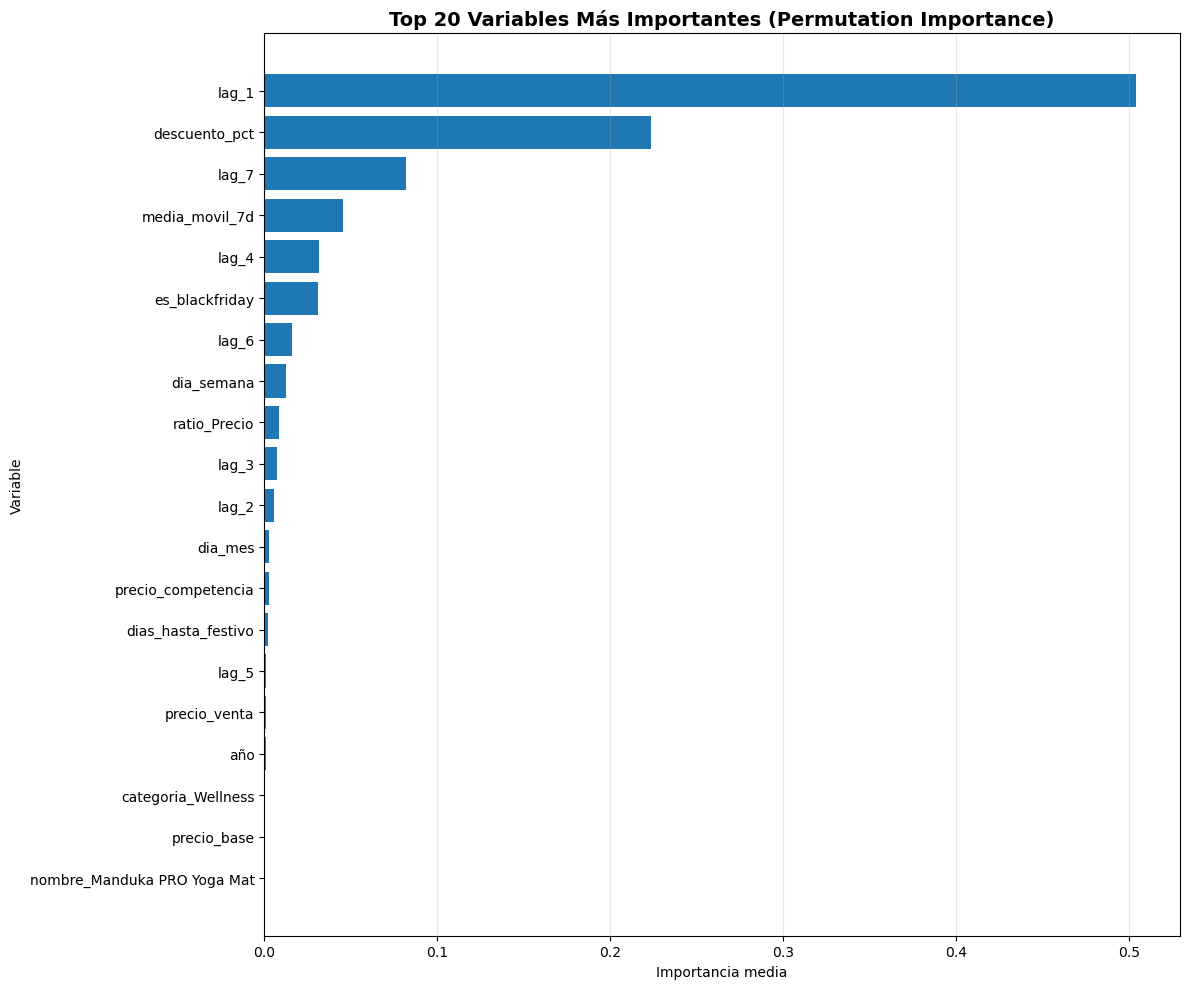


✓ Modelo final guardado en: ../models/model_final.joblib

🎉 ¡Entrenamiento completado con éxito!


In [119]:
# Importancia de variables y guardado del modelo final

print('🔍 Calculando importancia de variables...\n')

# Calcular la importancia por permutación
result = permutation_importance(modelo_final, X_full, y_full, n_repeats=10, random_state=42, n_jobs=-1)
importancias = pd.DataFrame({'variable': X_cols, 'importancia': result.importances_mean})
importancias = importancias.sort_values('importancia', ascending=False)

# Mostrar top 15 variables más importantes
print('='*60)
print('📊 TOP 15 VARIABLES MÁS IMPORTANTES')
print('='*60)
print(importancias.head(15).to_string(index=False))
print('='*60)

# Gráfico de importancia
plt.figure(figsize=(12,10))
top_n = 20
plt.barh(importancias['variable'].head(top_n), importancias['importancia'].head(top_n))
plt.gca().invert_yaxis()
plt.title(f'Top {top_n} Variables Más Importantes (Permutation Importance)', fontsize=14, fontweight='bold')
plt.xlabel('Importancia media')
plt.ylabel('Variable')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Guardar el modelo final
model_path = '../models/model_final.joblib'
joblib.dump(modelo_final, model_path)

print(f'\n✓ Modelo final guardado en: {model_path}')
print('\n🎉 ¡Entrenamiento completado con éxito!')
